In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### mape——data——func

In [3]:
def mape_choice_data(preDate, targetDate, dataLoad, dataTemp):
    try:
        targer_data = dataLoad.loc[preDate:targetDate]
        preDate_values = targer_data.iloc[0].values
    except Exception:
        print('您所选日期不在表中')
    choice_data_index = dataLoad.apply(lambda x: np.mean(np.abs(x - preDate_values)/preDate_values)*100, axis=1).sort_values()[:60].index
    return choice_data_index

### reshape_data_fot_training

In [4]:
def reshape_data(choice_data_index, load_train, data_temp):
    
    sc_L = MinMaxScaler()
    norm_load_train = pd.DataFrame(sc_L.fit_transform(load_train.values.reshape(-1,1)).reshape(-1,24))
    norm_load_train.index, norm_load_train.columns = load_train.index, load_train.columns 
    
    
    sc_T = MinMaxScaler()
    norm_temp_train = pd.DataFrame(sc_T.fit_transform(data_temp.values.reshape(-1,1)).reshape(-1,24))
    norm_temp_train.index, norm_temp_train.columns = data_temp.index, data_temp.columns
    
    
    in_model_data = np.zeros((24,2))
    out_model_data = np.zeros((24,1))
    for i in choice_data_index:
        try:
            a = norm_load_train.loc[i].values.reshape((1,24))
            b = norm_temp_train.loc[i + datetime.timedelta(days = 1)].values.reshape((1,24))
            c = np.concatenate((a,b)).T
            d = norm_load_train.loc[i + datetime.timedelta(days = 1)].values.reshape((24,1))
        except Exception:
            continue
        else:
            in_model_data = np.concatenate((in_model_data, c))
            out_model_data = np.concatenate((out_model_data, d))
    
    
    in_model_data = in_model_data[24:].reshape(-1,24,2)
    out_model_data = out_model_data[24:].reshape(-1,24)
    
    X_train, X_test, y_train, y_test = train_test_split(in_model_data, out_model_data, test_size=0.25)  #, random_state=42
    return X_train, X_test, y_train, y_test, sc_L, sc_T

### model_build

In [5]:
def modle_set():
    inputs=tf.keras.layers.Input(shape=(24, 2))
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
    model=tf.keras.layers.Conv1D(filters = 24, kernel_size = 1, activation = 'sigmoid')(model)#卷积层
    #model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)
    #model=tf.keras.layers.MaxPooling1D(pool_size = 48)(model)#池化层
    #model=tf.keras.layers.Dropout(0.03)(model)#droupout层
    #model=tf.keras.layers.GRU(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(24, activation='tanh')(model)
    #model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    outputs = tf.keras.layers.Dense(24)(model)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

### main

In [6]:
def main(data_load, data_temp, load_train, preDate, targetDate):
    
    choice_data_index = mape_choice_data(preDate, targetDate, data_load, data_temp)
    
    a = reshape_data(choice_data_index, load_train, data_temp)
    
    model = modle_set()
    
    history = model.fit(a[0], a[2], epochs = 30, batch_size = 6,shuffle=True,validation_data=(a[1], a[3])) 
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot( loss, label='Train Loss')
    plt.plot( val_loss, label='Test Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()
    
    
    targer_data = data_load.loc[preDate:targetDate]
    in_pred_load = a[4].transform(targer_data.iloc[0].values.reshape(-1,1))       #预测前一天的load
    in_pred_temp = a[5].transform(data_temp.loc[targetDate].values.reshape(-1,1)) #预测当天的温度
    
    
    in_pred = np.concatenate((in_pred_load, in_pred_temp), axis=1).reshape(1,24,2)
    pred_load = model.predict(in_pred)
    
    pred_load_really = a[4].inverse_transform(pred_load.reshape(-1,1)).flatten()
    
    ax = plt.figure(figsize=(10,5))
    plt.plot(pred_load_really, 'b')
    plt.plot(targer_data.iloc[1].values, 'r')
    plt.show()
    
    mapes = np.mean(np.abs(pred_load_really - targer_data.iloc[1].values)/targer_data.iloc[1].values)*100
    
    return pred_load_really, targer_data.iloc[1].values, mapes

In [7]:
a = np.array([1,1,1,1,1]).reshape(-1,1)
b = np.array([2,2,2,2,2]).reshape(-1,1)

In [8]:
np.concatenate((a,b), axis=1)

array([[1, 2],
       [1, 2],
       [1, 2],
       [1, 2],
       [1, 2]])

# outset

In [3]:
data_load = pd.read_csv('data_load.csv', parse_dates=['date'], index_col=['date'])
data_temp = pd.read_csv('data_temp.csv', parse_dates=['date'], index_col=['date'])

In [4]:
img = data_load.fillna(0).values.flatten()

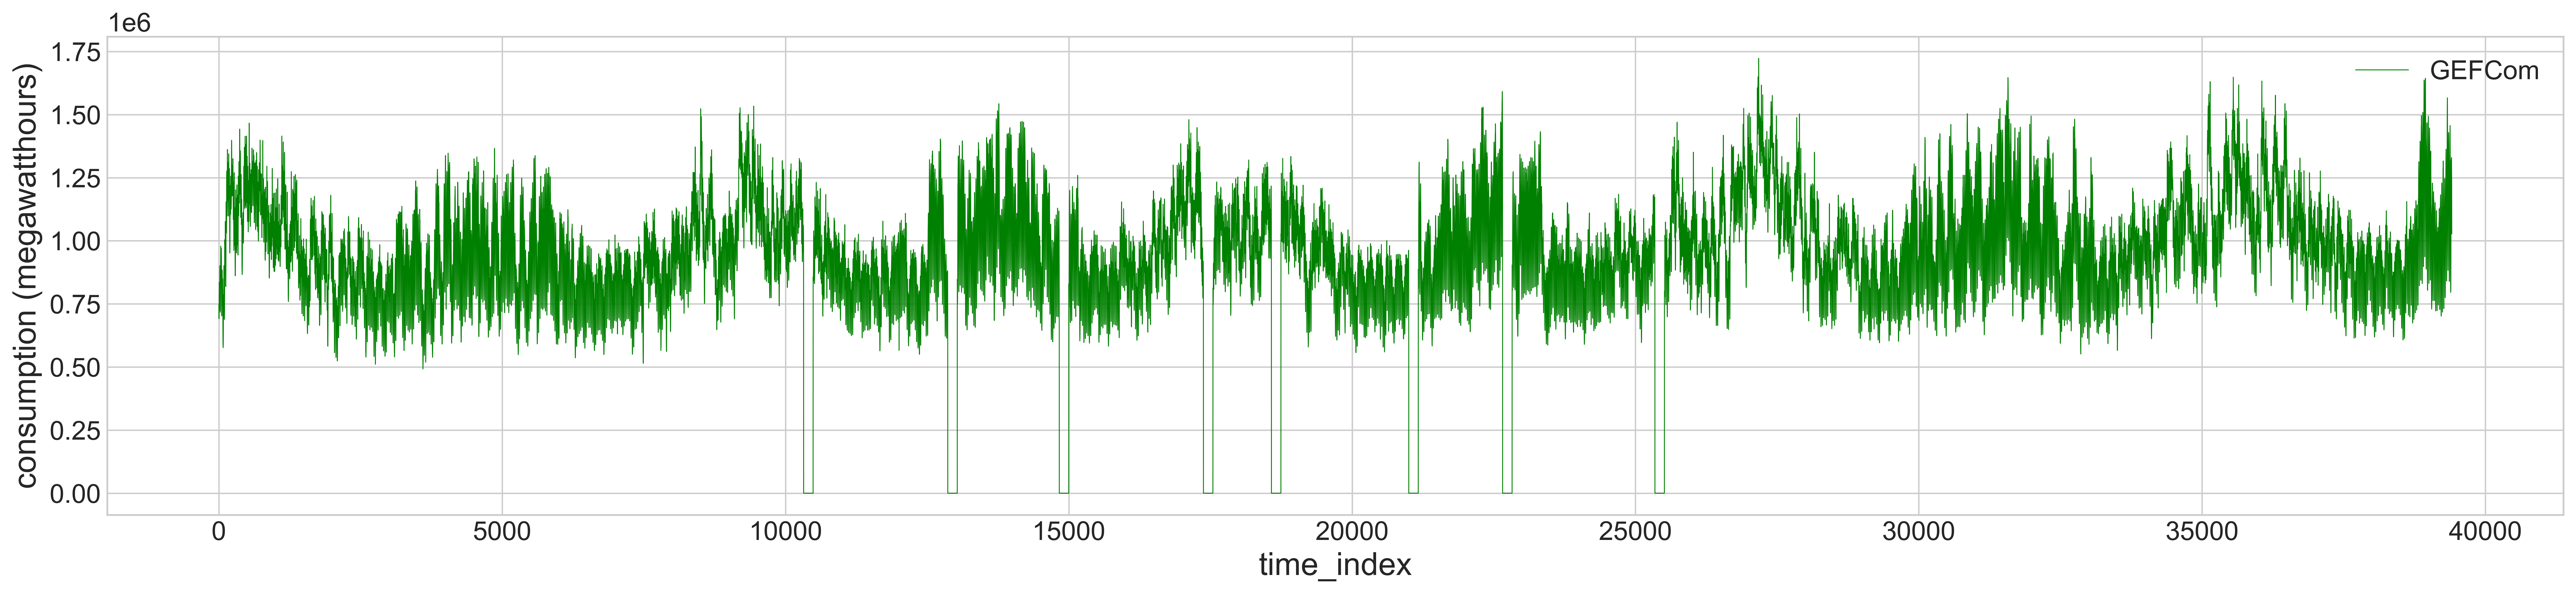

In [9]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25, 5), dpi=600)
#fig.patch.set_facecolor('red')
ax = fig.add_subplot(1,1,1)
plt.rcParams.update({"font.size":15})
#plt.title("validation_acc",fontsize=13)

ax.plot(img, 'green', label='GEFCom', linewidth=0.5)
ax.set_xlabel("time_index", fontsize=18)
ax.set_ylabel('consumption (megawatthours)', fontsize=18)
#plt.grid()
plt.legend()
plt.legend(loc='upper right') 
plt.savefig('GEFCom.jpg',dpi=600,bbox_inches = 'tight')

plt.show()

In [10]:
load_train = data_load.loc['2004-01-01':'2008-02-29'].dropna()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 24)            72        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 24)            600       
_________________________________________________________________
lstm (LSTM)                  (None, 24, 24)            4704      
_________________________________________________________________
lstm_1 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense (Dense)                (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_________________________________________________________

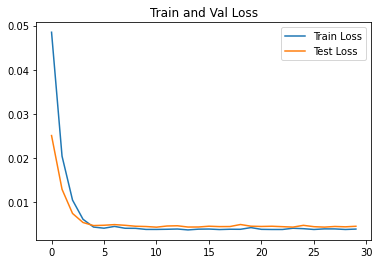

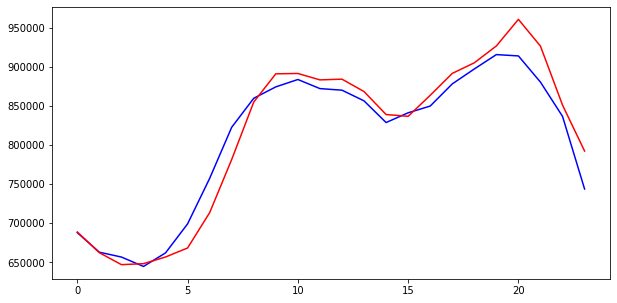

(array([688034.2 , 663018.9 , 656850.8 , 644830.4 , 662150.56, 699242.75,
        757388.8 , 822749.5 , 859821.9 , 874372.06, 883802.94, 872180.75,
        870155.06, 856501.5 , 828794.25, 841242.7 , 849855.25, 878163.56,
        897270.3 , 915639.94, 913926.44, 880430.94, 836666.  , 743846.3 ],
       dtype=float32),
 array([688879., 662415., 647124., 648369., 656907., 668443., 713557.,
        781537., 855035., 891083., 891501., 883315., 884236., 868385.,
        839026., 836749., 863585., 891578., 905142., 926691., 960690.,
        926428., 851076., 792357.]),
 2.131914939825832)

In [11]:
main(data_load, data_temp, load_train, '2008-05-10', '2008-05-11')

# mut_predict

In [12]:
listTarg = []
listAim = []
for i in range(1,29):
    
    if i <10:
       
        #mainSet(data, '2010-12-'+'0'+str(i), '2010-12-'+'0'+str(i+1))
        listTarg.append('2008-06-'+'0'+str(i))
    else:
        #mainSet(data, '2010-12-'+str(i), '2010-12-'+str(i+1))
        listTarg.append('2008-06-'+str(i))

for i in range(2,30):
    if i <10:
       
        #mainSet(data, '2010-12-'+'0'+str(i), '2010-12-'+'0'+str(i+1))
        listAim.append('2008-06-'+'0'+str(i))
    else:
        #mainSet(data, '2010-12-'+str(i), '2010-12-'+str(i+1))
        listAim.append('2008-06-'+str(i))

In [13]:
listTarg, listAim

(['2008-06-01',
  '2008-06-02',
  '2008-06-03',
  '2008-06-04',
  '2008-06-05',
  '2008-06-06',
  '2008-06-07',
  '2008-06-08',
  '2008-06-09',
  '2008-06-10',
  '2008-06-11',
  '2008-06-12',
  '2008-06-13',
  '2008-06-14',
  '2008-06-15',
  '2008-06-16',
  '2008-06-17',
  '2008-06-18',
  '2008-06-19',
  '2008-06-20',
  '2008-06-21',
  '2008-06-22',
  '2008-06-23',
  '2008-06-24',
  '2008-06-25',
  '2008-06-26',
  '2008-06-27',
  '2008-06-28'],
 ['2008-06-02',
  '2008-06-03',
  '2008-06-04',
  '2008-06-05',
  '2008-06-06',
  '2008-06-07',
  '2008-06-08',
  '2008-06-09',
  '2008-06-10',
  '2008-06-11',
  '2008-06-12',
  '2008-06-13',
  '2008-06-14',
  '2008-06-15',
  '2008-06-16',
  '2008-06-17',
  '2008-06-18',
  '2008-06-19',
  '2008-06-20',
  '2008-06-21',
  '2008-06-22',
  '2008-06-23',
  '2008-06-24',
  '2008-06-25',
  '2008-06-26',
  '2008-06-27',
  '2008-06-28',
  '2008-06-29'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 24)            72        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 24)            600       
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

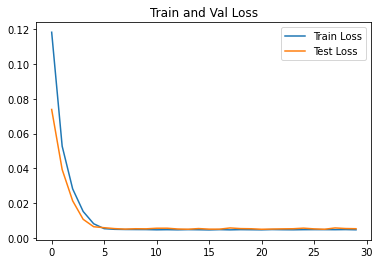

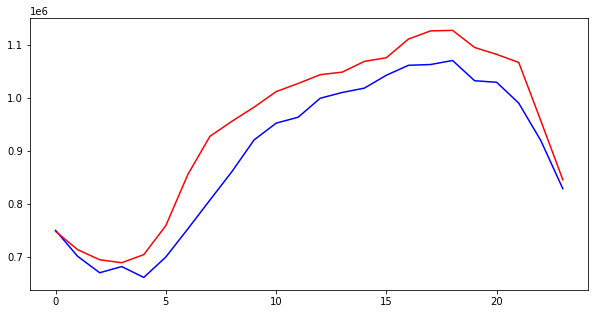

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 24, 24)            72        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 24)            600       
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_5 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

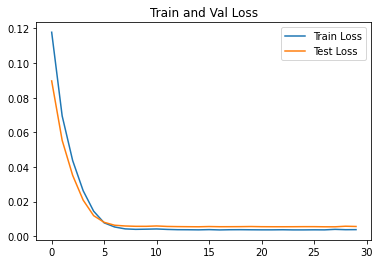

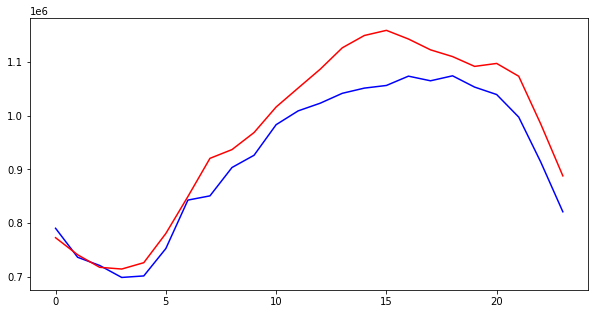

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 24, 24)            72        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 24, 24)            600       
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_7 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

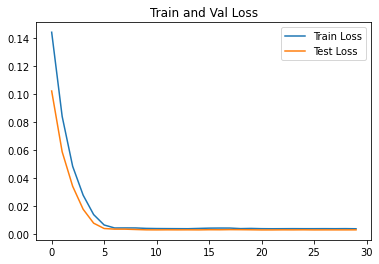

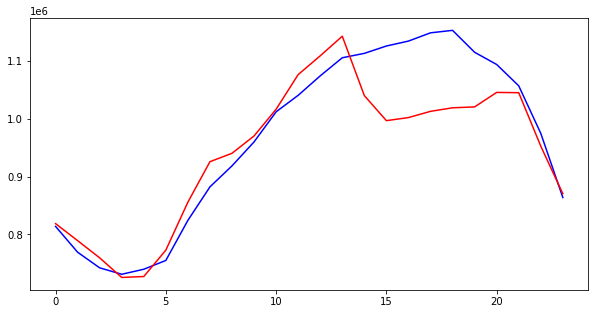

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 24)            72        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 24)            600       
_________________________________________________________________
lstm_8 (LSTM)                (None, 24, 24)            4704      
_________________________________________________________________
lstm_9 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

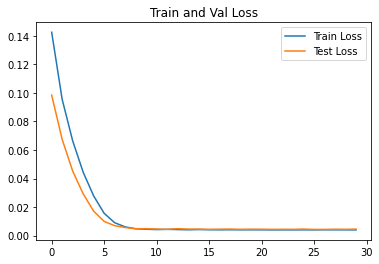

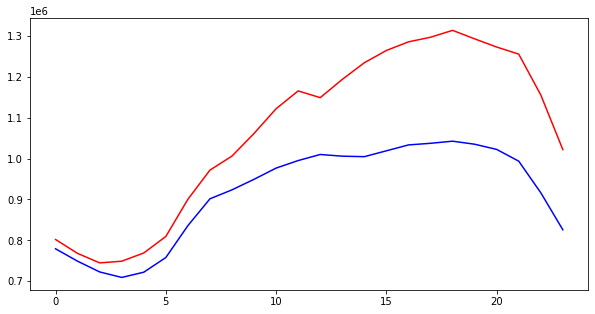

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_10 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_11 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

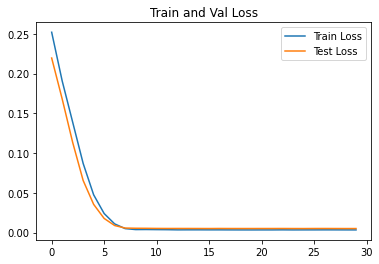

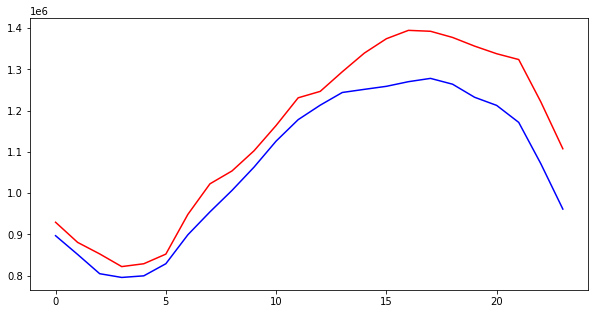

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_12 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_13 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_6 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

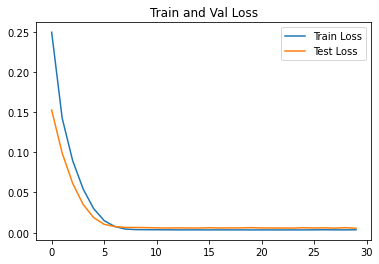

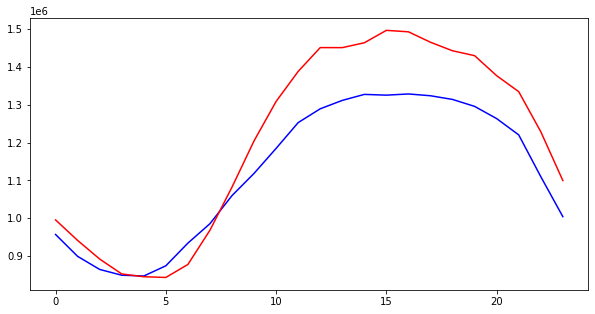

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_14 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_15 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

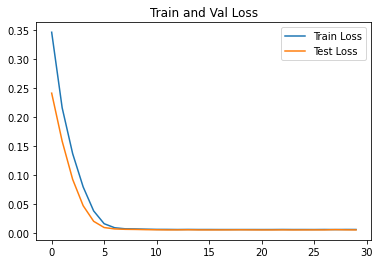

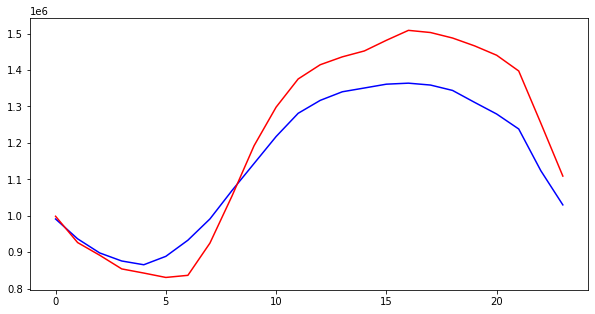

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_16 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_17 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

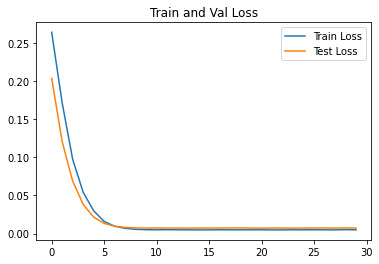

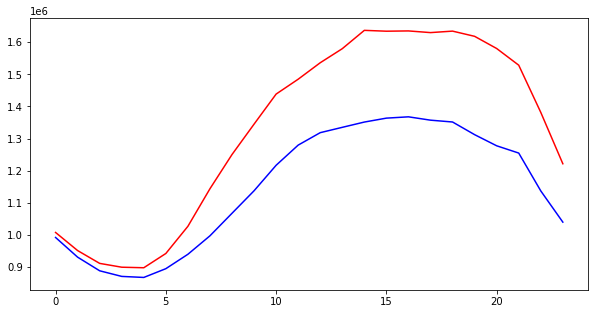

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_18 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_19 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
_______________________________________________________

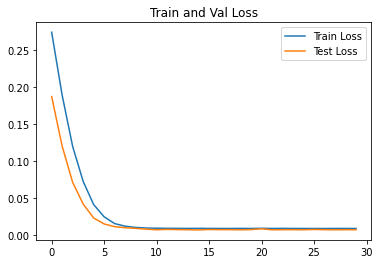

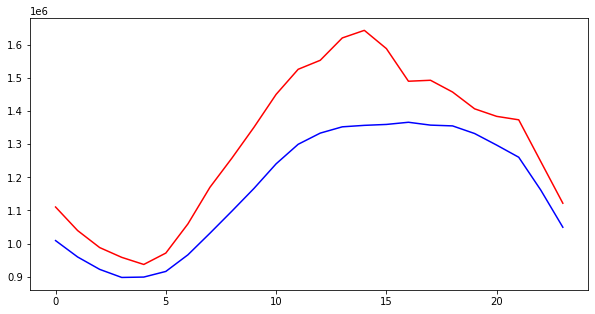

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_20 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_21 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

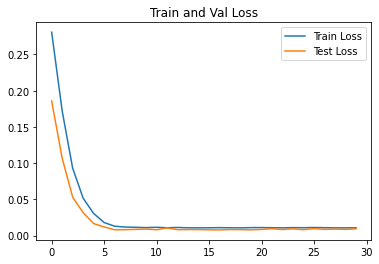

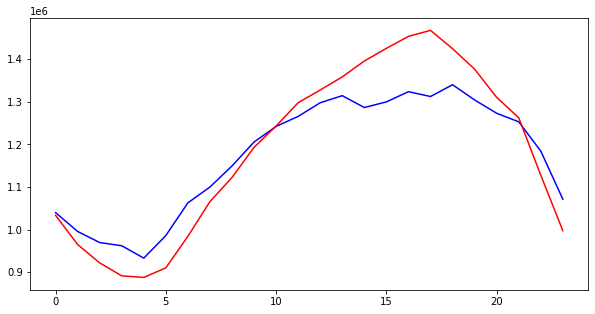

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_22 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_23 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_11 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

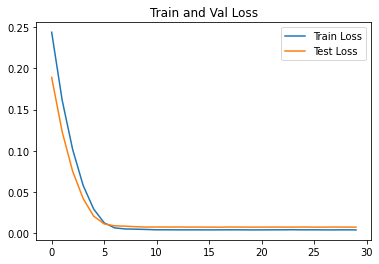

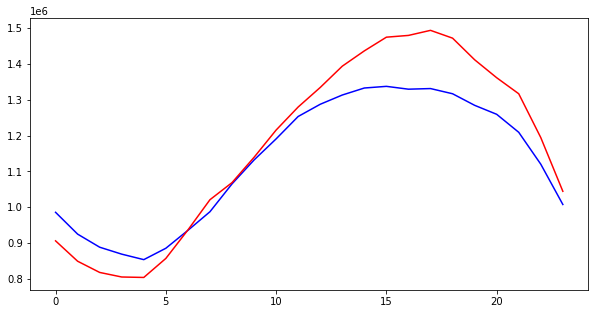

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_24 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_25 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

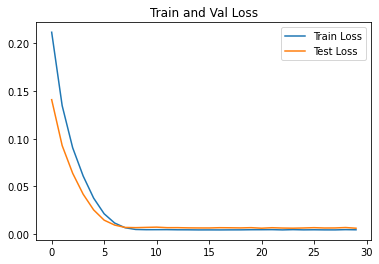

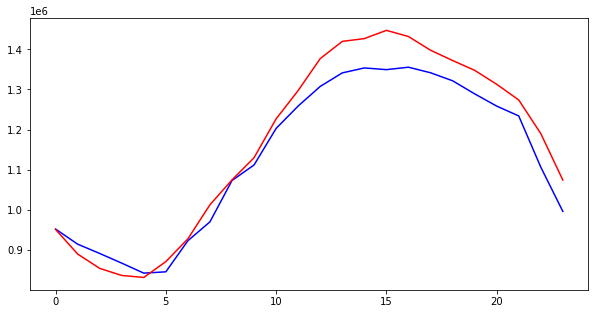

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_26 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_27 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_13 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

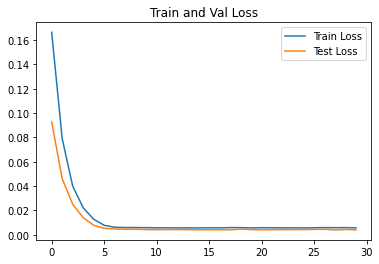

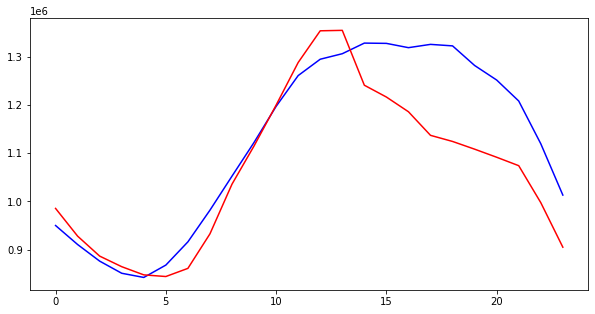

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_28 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_29 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_14 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

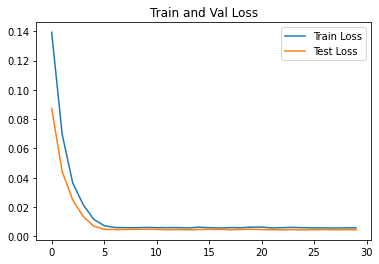

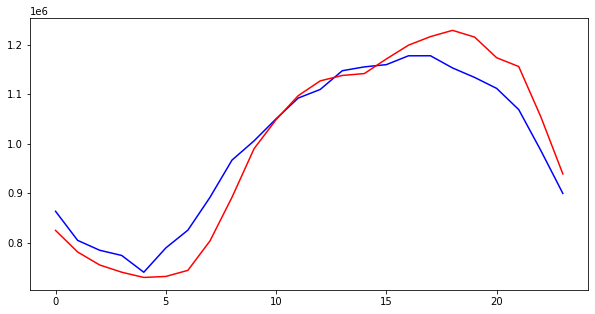

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_30 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_31 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_15 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

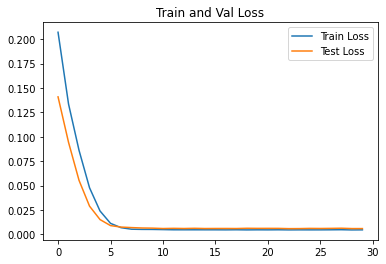

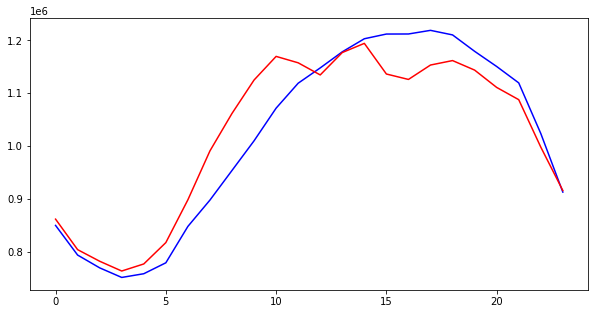

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_32 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_33 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_16 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

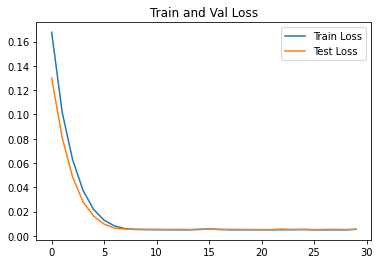

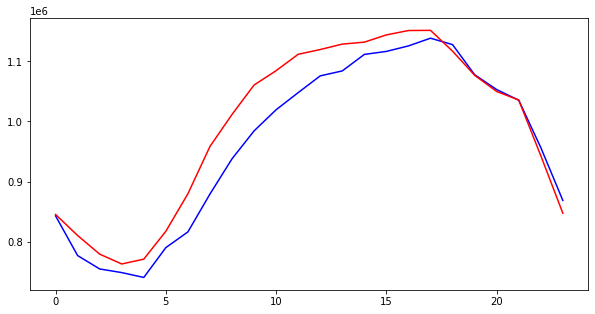

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_34 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_35 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_17 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

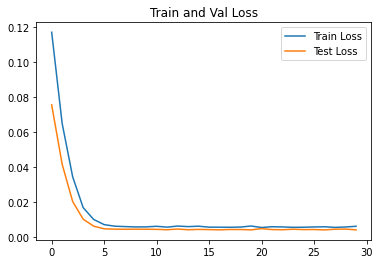

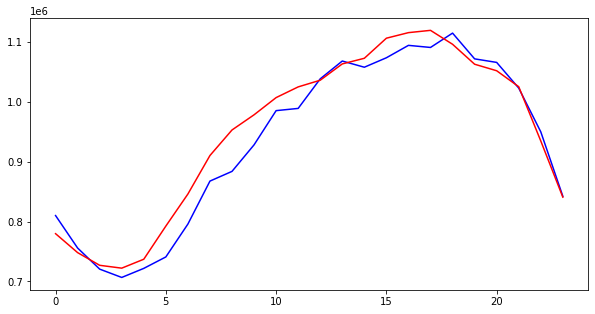

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_36 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_37 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_18 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

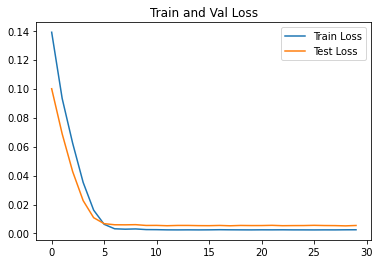

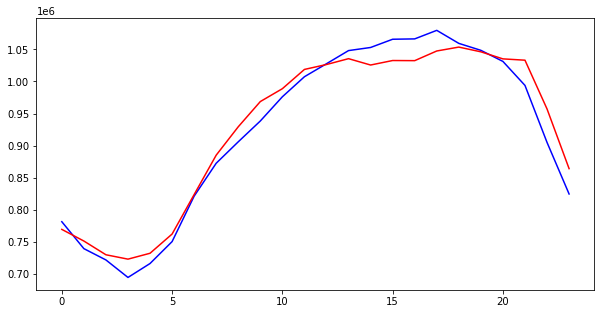

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_38 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_39 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_19 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

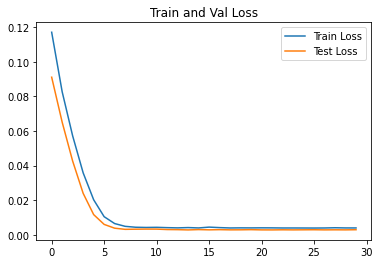

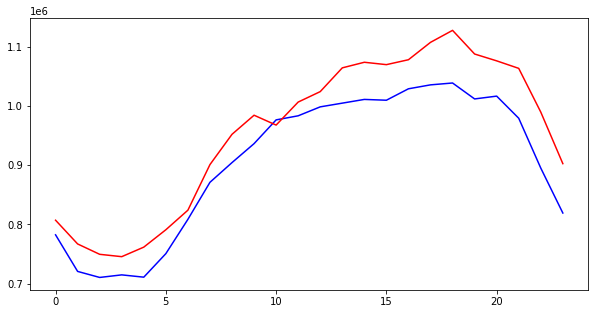

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_40 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_41 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_20 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

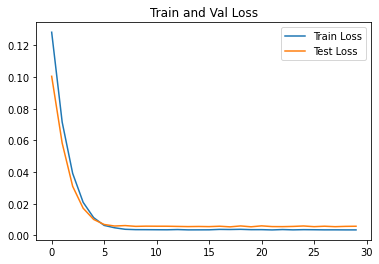

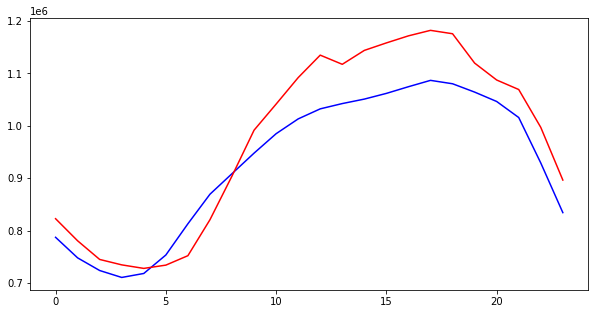

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_42 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_43 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_21 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

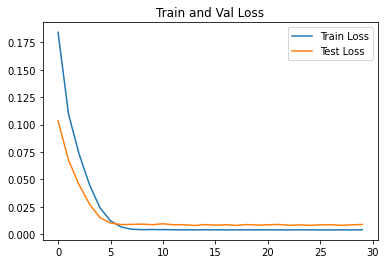

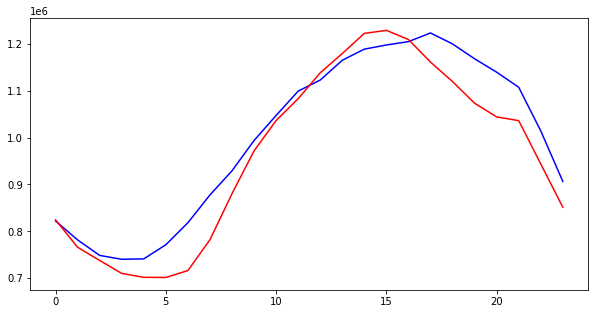

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_44 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_45 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_22 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

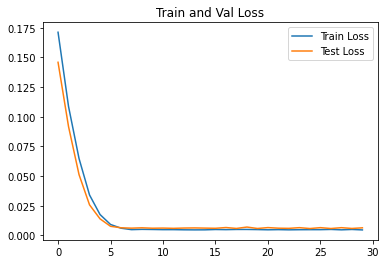

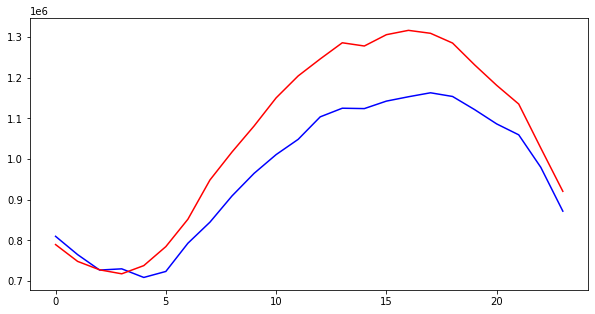

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_46 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_47 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_23 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

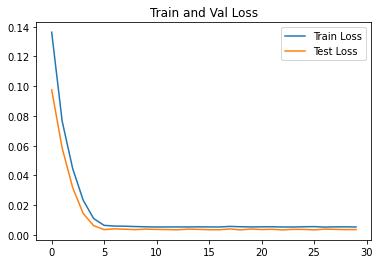

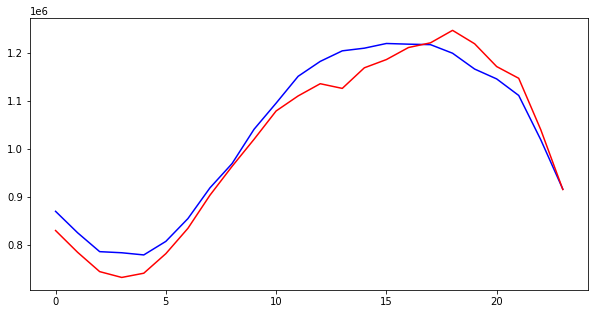

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_48 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_49 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_24 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

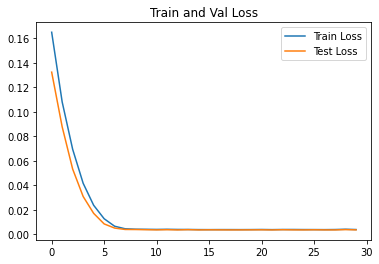

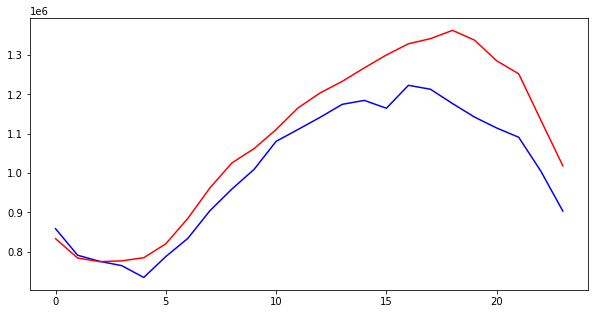

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_50 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_51 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_25 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

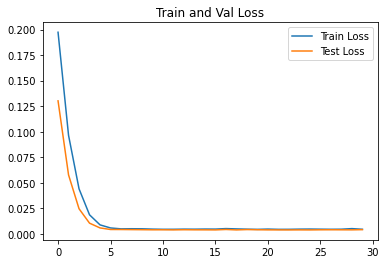

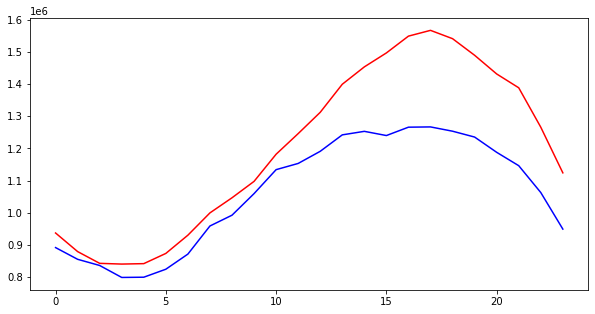

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_52 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_53 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_26 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

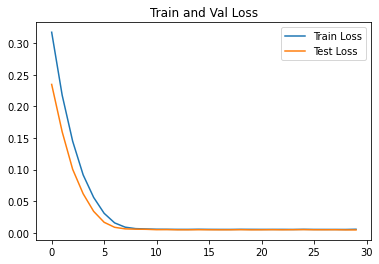

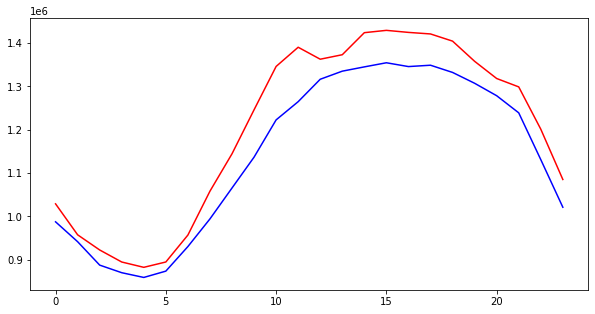

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_54 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_55 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_27 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

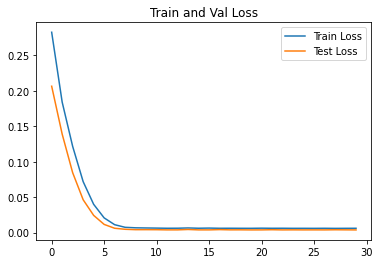

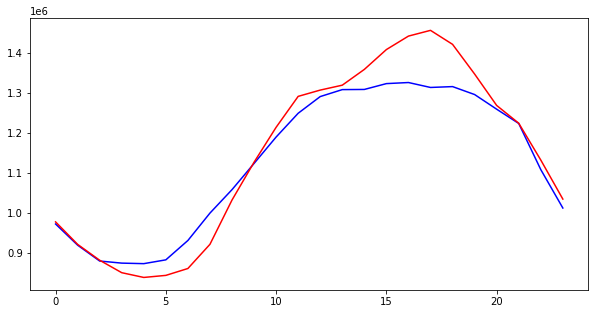

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 24, 2)]           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 24, 24)            72        
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 24, 24)            600       
_________________________________________________________________
lstm_56 (LSTM)               (None, 24, 24)            4704      
_________________________________________________________________
lstm_57 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dense_28 (Dense)             (None, 24)                600       
Total params: 10,680
Trainable params: 10,680
Non-trainable params: 0
______________________________________________________

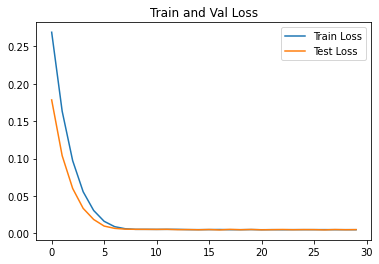

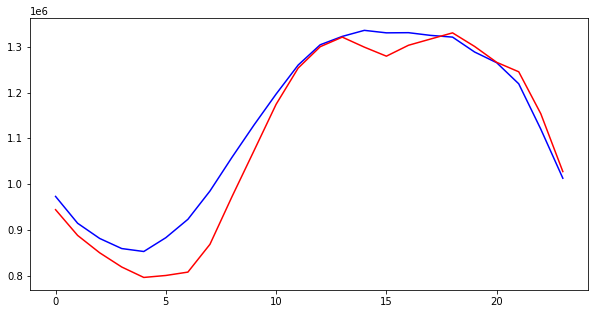

In [14]:
pred = np.array([])
true = np.array([])
mape_values = []
for i, j in zip(listTarg, listAim):
    pred_data_true, true_value, mapes=main(data_load, data_temp, load_train, i, j)
    pred = np.append(pred, pred_data_true)
    true = np.append(true, true_value)
    mape_values.append(mapes)

In [47]:
true

array([ 750671.,  727100.,  717096.,  721083.,  737287.,  799848.,
        888603.,  928797.,  927605.,  921145.,  918506.,  913718.,
        916947.,  916394.,  906634.,  881353.,  887420.,  896229.,
        889901.,  904930.,  940838.,  919096.,  869809.,  791197.,
        723507.,  676411.,  660291.,  671355.,  674463.,  688195.,
        705271.,  762085.,  825539.,  858513.,  877120.,  894636.,
        895564.,  895913.,  894745.,  896129.,  903343.,  907553.,
        887679.,  887854.,  911783.,  890088.,  811548.,  743053.,
        681410.,  642655.,  625746.,  624807.,  618755.,  627185.,
        649605.,  711517.,  789950.,  842494.,  853127.,  848778.,
        830993.,  830186.,  831741.,  842316.,  855301.,  862804.,
        863043.,  873457.,  937137.,  910270.,  821054.,  736002.,
        682020.,  661260.,  649587.,  639825.,  671237.,  747529.,
        860814.,  927078.,  937599.,  933580.,  933972.,  935290.,
        933151.,  927861.,  934652.,  936436.,  951031.,  9727

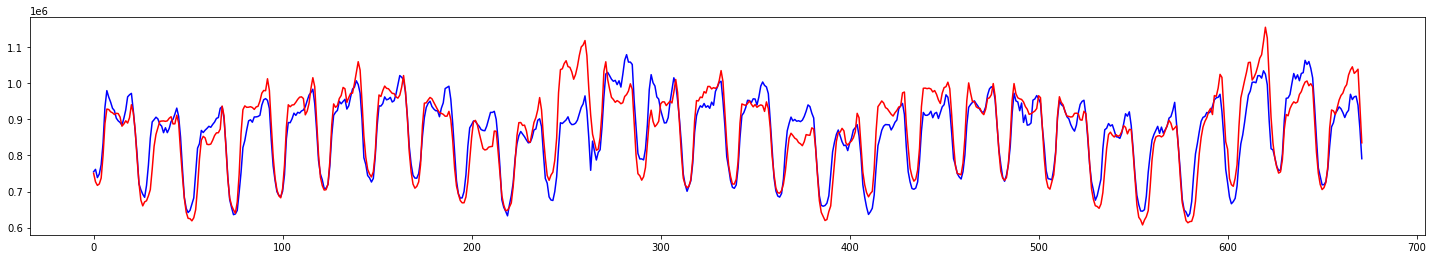

In [49]:
axs = plt.figure(figsize=(25,4))
plt.plot(pred, 'b')
plt.plot(true, 'r')
plt.show()

In [52]:
pd.DataFrame(true.reshape(-1,24)).to_csv('true_05.csv')

In [56]:
pd.DataFrame(mape_values).to_csv('mape05.csv')